# Capability Correlations

## 1. Database Matrix of Occurences

In order to establish a base for understading the basis of the work, we wish to understand the occurence of severall feedstocks, pricessing technologies and outputs in our database. 

For example, how many assets (patents, papers, etc) contain the mix of processing technology X for output Y? 

To understand this in a more general way, the AMICA database will be transformed in an [co-occurence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix). This means, in the above described example that the number of assets that contain that mix will be an entry in a matrix, whyle the corresponfing technology and output will be columns/lines of the matrix. 

### 1.1. Getting the data from Neo4j

The first step in the analysis is to get the data from the [AMICA](https://amica-pathfinder.net/) database. This data is stored in a graph database of the type [Neo4j](https://neo4j.com/). To get it, cypher queries must be designed. 

We start by importing necessary libraries.  

In [71]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

After that, we use [py2neo](http://py2neo.org/v3/) to establish a connection to our notebook. 

In [72]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

### 1.2. Designing the queries

Two queries to the database were designed, the first, only related to non interescting data, this means, looking for co-occurences of outputs-technologies, technologies-feedstocks and feedstocks-outputs. 

In [73]:
query_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                RETURN fs.term, pt.term, out.term, count(a)
                        """

The second query is designed to also fetch the intersections between different outputs, different processing technologies and different feedstocks. 

In [74]:
# issue: this query needs to be divided by two when building the matrix -> NON OPTIMIZED
process_variables = ['Feedstock', 'Output', 'ProcessingTech']
query_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                WHERE fs<>t
                                RETURN fs.term, t.term, count(a)
                      """

### 1.3. Building the Matrix: No Intersections

In order to get the axis of our co-occurence matrix we make all the necessary queries and gather all the names that appear in a `matrix_axis_names` list.

In [75]:
# Return dataframe with no interesections
data_no_intersections = DataFrame(connection_to_graph.data(query_no_interestions)).as_matrix()

# Get axis names from columns and add them in a list
feedstock_names = set(list(data_no_intersections[:, 1]))
processing_technology_names = set(list(data_no_intersections[:, 2]))
output_names = set(list(data_no_intersections[:, 3]))
matrix_axis_names = list(feedstock_names) + list(processing_technology_names) + list(output_names)

# Extra names that only appear in non-intersection query
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in matrix_axis_names:
                matrix_axis_names.append(name)

The co-occurence matrix will be called `matrix`. In order to get things started we need two things: 

- An empty matrix with the shape of the previously built axis:

In [76]:
matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])

- A function that given a certain name, returns the position of that name in a list:

In [77]:
def find_index(something, in_list):
    return in_list.index(something)

Finally, we can start building the first part of the matrix. To do so, we iterated over all of the rows of the data retreived in the `data_no_intersections` table. 

In [78]:
# for every row in original response
for row in data_no_intersections:
    # the last column is the frequency (count)
    frequency = row[0]
    indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
    # add frequency value to matrix position
    for pair in itertools.combinations(indexes, 2):
        matrix[pair[0], pair[1]] += frequency
        matrix[pair[1], pair[0]] += frequency

### 1.4. Building the Matrix: With Intersections

The second part of the matrix that should be built related to the second query. Intersecting categories. 

In [79]:
for category in process_variables:
    print 'Processing ', category
    process_data = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for row in process_data:
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        #     add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
            matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized

Processing  Feedstock
Processing  Output
Processing  ProcessingTech


### 1.5. Testing the co-occurence matrix

Let's start by getting some basic stats: 

In [80]:
print 'Rows:', matrix.shape[0]
print 'Columns:', matrix.shape[1]
print 'Mean: ', np.mean(matrix)
print 'Standart Deviation', np.std(matrix)
print 'Max: ', np.amax(matrix)
print 'Min: ', np.amin(matrix)

Rows: 342
Columns: 342
Mean:  1.31879894668
Standart Deviation 15.6499107707
Max:  1626.0
Min:  0.0


Normalize it: 

In [81]:
normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)

Let's check if the normalized and non-normalized matrixes are symetrical (they should).

In [82]:
def check_symmetric(a, tol):
    return np.allclose(a, a.T, atol=tol)

print 'The non normalized matrix is symmetrical: {}'.format(check_symmetric(matrix, 1e-8))
print 'The normalized matrix is symmetrical: {}'.format(check_symmetric(normalized_matrix, 1e-8))

The non normalized matrix is symmetrical: True
The normalized matrix is symmetrical: True


The diagonal of the non-normalized matrix is all zeros: 

In [83]:
for column_number in range(matrix.shape[0]):
    if matrix[column_number, column_number] != 0:
        print 'Non-zero entry found in entry {}'.format(column_number)

### 1.6. Printing the matrix

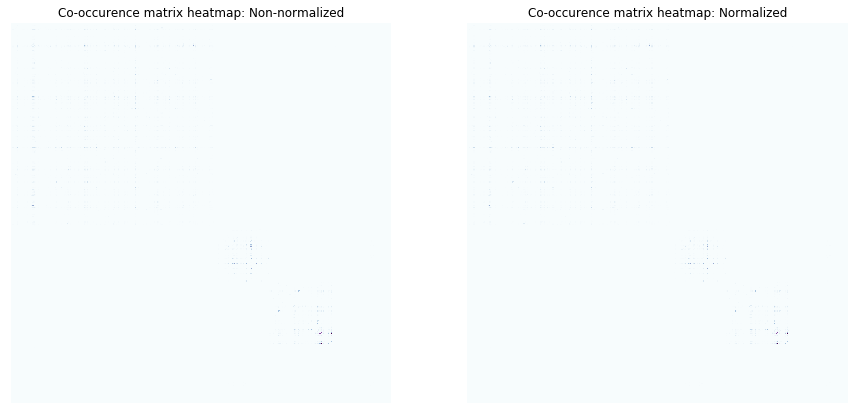

In [85]:
plt.subplots(2,1,figsize=(15,15))

plt.subplot(121)
sns.heatmap(matrix, cmap='BuPu', cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Non-normalized')

plt.subplot(122)
sns.heatmap(normalized_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Normalized')
plt.show()